### About the Project: 

The Sakila database basically holds the information of a company that rents movies. Since this is a famous database I will be answering some query questions I found. I will also give explanations for those who want to learn. To make life easier for you I have provided the schema of the database below.  

I will be adding new queries as I find or come up with new questions.

I hope it helps!

![](https://www.postgresqltutorial.com/wp-content/uploads/2018/03/dvd-rental-sample-database-diagram.png)

In [3]:
# Firstly, I am going to import the libraries that I will need.

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
db_path = "sqlite-sakila.db"
# db_path = "C:/Users/Asus/sakila_new.db"
conn = sqlite3.connect(db_path)

In [5]:
# Now lets see the tables we have in our database
tables = pd.read_sql(""" select *
                        from sqlite_master 
                        where type='table'
                        order by name;
                        """, conn)

tables

,type,name,tbl_name,rootpage,sql
0,table,actor,actor,2,CREATE TABLE actor (\n actor_id numeric NOT N...
1,table,address,address,10,CREATE TABLE address (\n address_id int NOT N...
2,table,category,category,15,CREATE TABLE category (\n category_id SMALLIN...
3,table,city,city,7,"CREATE TABLE city (\n city_id int NOT NULL,\n..."
4,table,country,country,5,CREATE TABLE country (\n country_id SMALLINT ...
5,table,customer,customer,19,CREATE TABLE customer (\n customer_id INT NOT...
6,table,film,film,24,"CREATE TABLE film (\n film_id int NOT NULL,\n..."
7,table,film_actor,film_actor,28,CREATE TABLE film_actor (\n actor_id INT NOT ...
8,table,film_category,film_category,33,CREATE TABLE film_category (\n film_id INT NO...
9,table,film_text,film_text,37,CREATE TABLE film_text (\n film_id SMALLINT N...


---

##### Before going into the questions I first want to see if there are any rows in the actors table with the same first_name and last_name but different actor_id.  

I want to learn this because this kind of duplication may alter our results in the following queries.  

So, to prevent that, I am going to check if such a duplication exists.


In [6]:
df = pd.read_sql_query(""" select actor_id, first_name, last_name
                            from actor
                            where (first_name, last_name) in (
                            select first_name, last_name
                            from actor
                            group by first_name, last_name
                            having count(actor_id) > 1)
                            """, conn)


df

# As it can be seen from the output below actress Susan Davis appears two times with different actor_id's.
# I think that in the film industry it is not likely for two people to use the same name and last name.
# So, I am going to take it as a duplicate and adjust my queries accordingly when using this table.

,actor_id,first_name,last_name
0,101,SUSAN,DAVIS
1,110,SUSAN,DAVIS


---

#### Question: Get the actors in each movie

In [7]:
# I am going to group by title and also full_name because we saw that there was a duplicate in the actor table.

df = pd.read_sql_query(""" select title, first_name || ' ' || last_name AS full_name
                        from film 
                        inner join film_actor on film.film_id = film_actor.film_id
                        inner join actor on film_actor.actor_id = actor.actor_id
                        group by title, full_name
                        order by title, full_name
                        """, conn)
df


# So, for example, the actors who starred in the movie Zorro Ark were Ian Tandy, Lisa Monroe and Nick Degeneres

,title,full_name
0,ACADEMY DINOSAUR,CHRISTIAN GABLE
1,ACADEMY DINOSAUR,JOHNNY CAGE
2,ACADEMY DINOSAUR,LUCILLE TRACY
3,ACADEMY DINOSAUR,MARY KEITEL
4,ACADEMY DINOSAUR,MENA TEMPLE
...,...,...
5457,ZOOLANDER FICTION,PENELOPE CRONYN
5458,ZOOLANDER FICTION,WHOOPI HURT
5459,ZORRO ARK,IAN TANDY
5460,ZORRO ARK,LISA MONROE


---

#### Question: How many actors starred in each movie?

This question is basically a derivation of the question above. I was curious and wanted to investigate it.

In [8]:
df = pd.read_sql_query(""" with t1 as (select title, first_name || ' ' || last_name AS full_name
                        from film 
                        left join film_actor on film.film_id = film_actor.film_id
                        left join actor on film_actor.actor_id = actor.actor_id
                        group by title, full_name)
                        
                        
                        select title, count(full_name) as count_of_actors
                        from t1
                        group by title
                        order by count_of_actors desc
                        """, conn)
df



# Most number of actors that starred in a movie was "Lambs Cincinatti" with a count of 15.
# There were 3 movies with no actors. 

,title,count_of_actors
0,LAMBS CINCINATTI,15
1,RANDOM GO,13
2,MUMMY CREATURES,13
3,DRACULA CRYSTAL,13
4,CRAZY HOME,13
...,...,...
995,BRIDE INTRIGUE,1
996,BAKED CLEOPATRA,1
997,SLACKER LIAISONS,0
998,FLIGHT LIES,0


---

#### Question: How many movies has each actor played in?

In [9]:
# I have used left join because there could have been actors who has played in 0 movies.


df = pd.read_sql_query(""" select first_name || ' ' || last_name as full_name, 
                        count(film.film_id) as movie_count
                        from actor 
                        left join film_actor on film_actor.actor_id = actor.actor_id
                        left join film on film.film_id = film_actor.film_id
                        group by first_name || ' ' || last_name
                        order by movie_count desc, full_name
                        """, conn)
df

,full_name,movie_count
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
...,...,...
194,SISSY SOBIESKI,18
195,JULIA ZELLWEGER,16
196,JUDY DEAN,15
197,JULIA FAWCETT,15


---

##### To take things further I can also get only the top 10 actors that starred most in the movies:

In [10]:
df = pd.read_sql_query(""" with t1 as (select first_name || ' ' || last_name as full_name, 
                        count(film.film_id) as movie_count,
                        dense_rank() over(order by count(film.film_id) desc) as d_rank
                        from actor 
                        left join film_actor on film_actor.actor_id = actor.actor_id
                        left join film on film.film_id = film_actor.film_id
                        group by first_name || ' ' || last_name
                        order by d_rank)
            
                        select * from t1
                        where d_rank<=10
                        """, conn)

df



,full_name,movie_count,d_rank
0,SUSAN DAVIS,54,1
1,GINA DEGENERES,42,2
2,WALTER TORN,41,3
3,MARY KEITEL,40,4
4,MATTHEW CARREY,39,5
5,SANDRA KILMER,37,6
6,SCARLETT DAMON,36,7
7,VIVIEN BASINGER,35,8
8,VAL BOLGER,35,8
9,UMA WOOD,35,8


---

#### Question: Are there movies that are not in the inventory and if yes how many are there?

In [11]:
df = pd.read_sql_query(""" select count(film.film_id) as count
                        from film
                        left join inventory on film.film_id = inventory.film_id
                        where inventory.inventory_id is null
                        """, conn)



df

,count
0,42


---

#### Question: Get the number of times each movie which is available for rent has been rented and their total revenue

In [12]:
# I have came to discover that there are payments for rentals that does not exist. Let's see them.
# We need to take them into account while answering related questions.

df = pd.read_sql_query(""" select * from payment
                        where payment.rental_id is null
                        """, conn)
df


,payment_id,customer_id,staff_id,rental_id,amount,payment_date,last_update
0,424,16,1,None,1.99,2005-06-18 04:56:12.000,2021-03-06 15:56:00
1,7011,259,2,None,1.99,2005-08-23 06:13:16.000,2021-03-06 15:56:55
2,10840,401,1,None,0.99,2005-07-12 06:26:10.000,2021-03-06 15:57:27
3,14675,546,1,None,3.99,2005-07-30 21:16:20.000,2021-03-06 15:57:58
4,15458,577,2,None,0.99,2005-05-27 00:46:39.000,2021-03-06 15:58:04


In [13]:
# ANSWER:

df = pd.read_sql_query(""" select title, count(rental.rental_id) as times_rented, 
                        sum(amount) as total_amount
                        from film
                        inner join inventory on film.film_id=inventory.film_id
                        inner join rental on inventory.inventory_id=rental.inventory_id
                        inner join payment on rental.rental_id=payment.rental_id
                        group by film.film_id
                        order by times_rented desc, total_amount desc
                        
                        """, conn)
df

# As it can be seen below, Bucket Brotherhood was the most rented movie with a count of 34

# if you want to include all the movies even the ones that are not for rent just use left join in
    # all of the joins. You will see all the movies including the ones that are not available for rent
        # Those movies would have a times_rented value of 0 and total_amount value of NaN.
            # You can change the NaN by coalesce so that coalesce(sum(amount), 0) 

,title,times_rented,total_amount
0,BUCKET BROTHERHOOD,34,180.66
1,ROCKETEER MOTHER,33,116.67
2,SCALAWAG DUCK,32,172.68
3,RIDGEMONT SUBMARINE,32,130.68
4,FORWARD TEMPLE,32,128.68
...,...,...,...
953,GLORY TRACY,5,14.95
954,FREEDOM CLEOPATRA,5,5.95
955,TRAIN BUNCH,4,24.96
956,HARDLY ROBBERS,4,15.96


In [14]:
# However, the movie that brought the most renvenue was:
df = pd.read_sql_query(""" select title, count(rental.rental_id) as times_rented, 
                        coalesce(sum(amount), "not available for rent") as total_amount
                        from film
                        inner join inventory on film.film_id=inventory.film_id
                        inner join rental on inventory.inventory_id=rental.inventory_id
                        left join payment on rental.rental_id=payment.rental_id
                        group by film.film_id
                        order by total_amount desc
                        limit 1
                        """, conn)
df

# Telegraph Voyage which was rented 27 times and brought a revenue of 231.73 dollars

,title,times_rented,total_amount
0,TELEGRAPH VOYAGE,27,231.73


To open space in the inventory the company coould remove the least rented movies foor example and replace them with movies that are not available for rent but have a high rental_rate. Let's see those movies that have a high rental rate but are not in the inventory below.

---

#### Question: Get the movies rental_rate that are not in the inventory.

In [15]:
df = pd.read_sql_query(""" select film.film_id, title, rental_rate from film
                           left join inventory on film.film_id=inventory.film_id
                           where inventory.inventory_id is null
                           order by rental_rate desc
                        """, conn)
df

# So it might increase the company's profit to replace the least rented movies with 
    # movies with a high rental_rate but are not in the inventory
        # such as replacing "Mixed Doors" and "Hardly Robbers" with "Chinatown Gladiator" and "Dazed Punk".

,film_id,title,rental_rate
0,144,CHINATOWN GLADIATOR,4.99
1,171,COMMANDMENTS EXPRESS,4.99
2,192,CROSSING DIVORCE,4.99
3,195,CROWDS TELEMARK,4.99
4,217,DAZED PUNK,4.99
5,359,GLADIATOR WESTWARD,4.99
6,386,GUMP DATE,4.99
7,607,MUPPET MILE,4.99
8,671,PERDITION FARGO,4.99
9,713,RAINBOW SHOCK,4.99


---

#### Question: How many customers have not returned more than 1 DVD?

In [16]:
# Emailing these customer could be a strategy.
# Blacklisting these customers and not renting them other DVD's unless they return the old ones could be another strategy.


df = pd.read_sql_query(""" select customer.first_name, customer.last_name, customer.email, count(rental.rental_id) as not_returned_count 
                        from rental
                        inner join customer on rental.customer_id=customer.customer_id
                        where return_date is null
                        group by rental.customer_id
                        having not_returned_count>1
                        order by not_returned_count
                        """, conn)


df

# For example, Tammy Sanders has not returned 3 DVD's that she has rented. 

,first_name,last_name,email,not_returned_count
0,HELEN,HARRIS,HELEN.HARRIS@sakilacustomer.org,2
1,CAROLYN,PEREZ,CAROLYN.PEREZ@sakilacustomer.org,2
2,CHRISTINE,ROBERTS,CHRISTINE.ROBERTS@sakilacustomer.org,2
3,HEATHER,MORRIS,HEATHER.MORRIS@sakilacustomer.org,2
4,MILDRED,BAILEY,MILDRED.BAILEY@sakilacustomer.org,2
5,FLORENCE,WOODS,FLORENCE.WOODS@sakilacustomer.org,2
6,GAIL,KNIGHT,GAIL.KNIGHT@sakilacustomer.org,2
7,CATHY,SPENCER,CATHY.SPENCER@sakilacustomer.org,2
8,ANNETTE,OLSON,ANNETTE.OLSON@sakilacustomer.org,2
9,LUCY,WHEELER,LUCY.WHEELER@sakilacustomer.org,2


---

#### Question: How many movies has each customer rented?

In [17]:
df = pd.read_sql_query(""" select first_name, last_name, count(rental_id) rental_count
                            from rental
                            inner join customer on rental.customer_id = customer.customer_id
                            group by rental.customer_id
                            order by rental_count desc
                            """, conn)
df


# As it can be seen from the output the customer who rented the most number of movies was Eleanor Hunt.

,first_name,last_name,rental_count
0,ELEANOR,HUNT,46
1,KARL,SEAL,45
2,CLARA,SHAW,42
3,MARCIA,DEAN,42
4,TAMMY,SANDERS,41
...,...,...,...
594,CAROLINE,BOWMAN,15
595,KATHERINE,RIVERA,14
596,TIFFANY,JORDAN,14
597,LEONA,OBRIEN,14


In [18]:
df = pd.read_sql_query(""" with tb1 as (select first_name, last_name, count(rental_id) rental_count,
                            dense_rank() over(order by count(rental_id) desc) as d_rank
                            from rental
                            inner join customer on rental.customer_id = customer.customer_id
                            group by rental.customer_id
                            order by rental_count desc)
                            
                            select * 
                            from tb1
                            where d_rank <=3
                            """, conn)
df

# So giving a free dvd to the customers who have rented the most DVD's could be encouraging
        # and might increase revenue.

,first_name,last_name,rental_count,d_rank
0,ELEANOR,HUNT,46,1
1,KARL,SEAL,45,2
2,CLARA,SHAW,42,3
3,MARCIA,DEAN,42,3


---


#### Question: Most rented movies by genre and how much were payed for them 

In [19]:
df = pd.read_sql_query(""" select * from payment
where rental_id is null
                        """, conn)
df

,payment_id,customer_id,staff_id,rental_id,amount,payment_date,last_update
0,424,16,1,None,1.99,2005-06-18 04:56:12.000,2021-03-06 15:56:00
1,7011,259,2,None,1.99,2005-08-23 06:13:16.000,2021-03-06 15:56:55
2,10840,401,1,None,0.99,2005-07-12 06:26:10.000,2021-03-06 15:57:27
3,14675,546,1,None,3.99,2005-07-30 21:16:20.000,2021-03-06 15:57:58
4,15458,577,2,None,0.99,2005-05-27 00:46:39.000,2021-03-06 15:58:04


In [20]:
# I can left joining the payment table because there may be records in the rental table
    # which I dont want to exclude in order to get the correct rental_count.
        # But notice that people pay when they rent the DVD's.
            # Hence, every rental_id exists in the rental table also exists in payment table.
                # So, both inner join and left join would do just fine which would also prevent the above problem.

    
df = pd.read_sql_query(""" select category.name as genre, 
                        count(rental.rental_id) as rental_count,
                        sum(payment.amount) as total_amount
                        from category
                        inner join film_category on category.category_id = film_category.category_id
                        inner join inventory on film_category.film_id = inventory.film_id
                        inner join rental on inventory.inventory_id = rental.inventory_id
                        inner join payment on rental.rental_id = payment.rental_id
                        group by category.name
                        order by rental_count desc               
                        """, conn)
df

# So, in terms of revenue, music category was the genre that brought the least revenue which is
    # followed by travel and classics genres.


# In addition, Sports was the genre which had the highest rentals.
    # Music was the genre which had the least rentals.

,genre,rental_count,total_amount
0,Sports,1179,5314.21
1,Animation,1166,4656.30
2,Action,1112,4375.85
3,Sci-Fi,1101,4756.98
4,Family,1096,4226.07
5,Drama,1060,4587.39
6,Documentary,1050,4217.52
7,Foreign,1033,4270.67
8,Games,969,4281.33
9,Children,945,3655.55


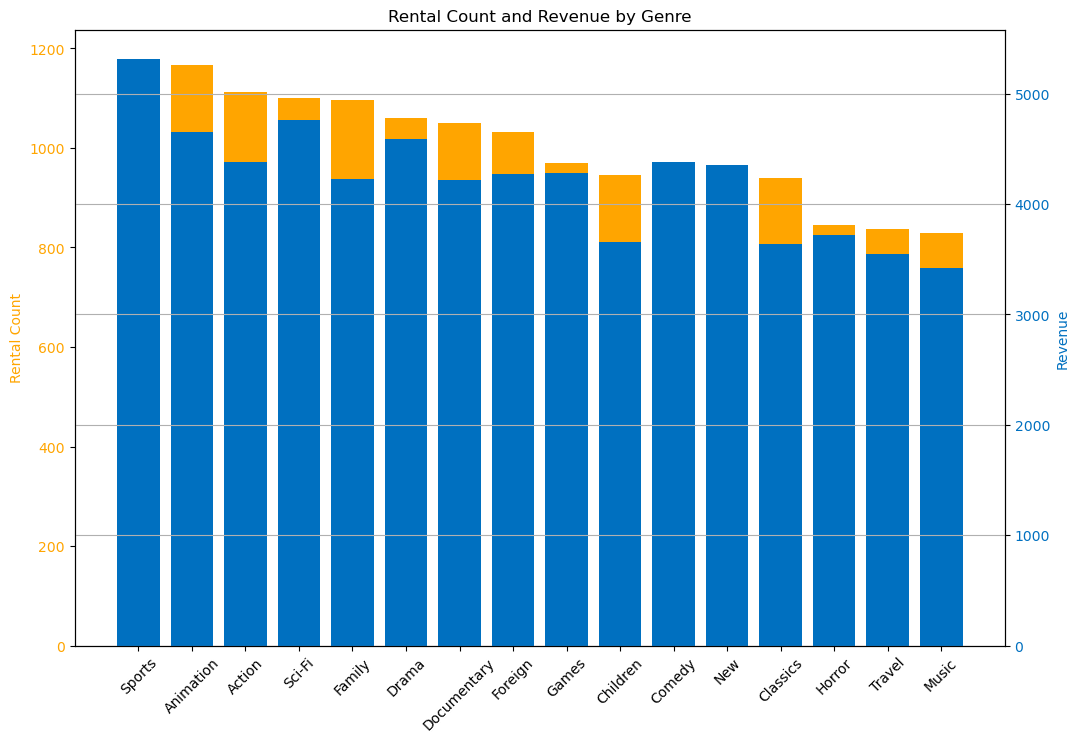

In [21]:
# Let's use a graph for this query.

fig, ax1 = plt.subplots(figsize=(12, 8))

plt.title("Rental Count and Revenue by Genre")


ax1.bar(df['genre'], df['rental_count'], color='#ffa500')
ax1.set_ylabel('Rental Count', color='#ffa500')
ax1.tick_params(axis='y', labelcolor='#ffa500')


ax2 = ax1.twinx()

ax2.bar(df['genre'], df['total_amount'], color='#0070C0')
ax2.set_ylabel('Revenue', color='#0070C0')
ax2.tick_params(axis='y', labelcolor='#0070C0')

plt.xlabel('Genre')

plt.grid(visible=True, which='both', axis='y')

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)



plt.show()

---

#### Question: Rental Count and Revenue by Genre and Date

In [22]:
df = pd.read_sql_query(""" select category.name as genre, 
                        count(rental.rental_id) as rental_count,
                        sum(payment.amount) as total_amount,
                        strftime('%Y-%m', rental.rental_date) as date
                        from category
                        inner join film_category on category.category_id = film_category.category_id
                        inner join inventory on film_category.film_id = inventory.film_id
                        inner join rental on inventory.inventory_id = rental.inventory_id
                        inner join payment on rental.rental_id = payment.rental_id
                        group by 1, 4
                        order by date               
                        """, conn)
df.head()
    

,genre,rental_count,total_amount,date
0,Action,87,371.13,2005-05
1,Animation,74,289.26,2005-05
2,Children,71,288.29,2005-05
3,Classics,62,227.38,2005-05
4,Comedy,72,295.28,2005-05


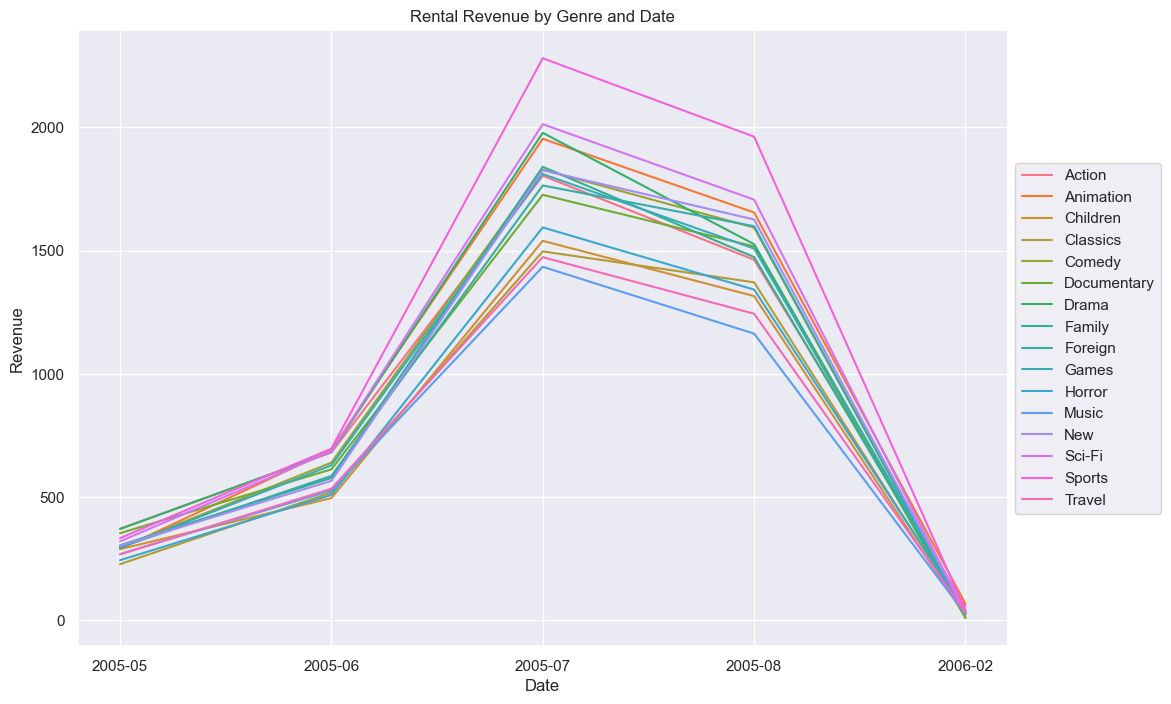

In [23]:
# Let's now plot the Rental Revenue by Genre and Date

sns.set(style='darkgrid')

sns.set(rc={'figure.figsize':(12,8)})

ax = sns.lineplot(data=df, x="date", y="total_amount", hue="genre")

ax.set_title("Rental Revenue by Genre and Date")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.show()





---

#### Question: How many times each movie was rented by genre (for the movies which are available for rent)

In [24]:
df = pd.read_sql_query("""select category.name as genre, film.title,
                        count(rental.rental_id) as rental_count
                        from category
                        inner join film_category on category.category_id = film_category.category_id
                        inner join film on film_category.film_id = film.film_id
                        inner join inventory on film.film_id=inventory.film_id
                        inner join rental on inventory.inventory_id = rental.inventory_id
                        group by 1,2
                        order by rental_count desc """, conn)

df

# As it can be seen from the output there are movies in the same genre that have been rented same numberof times.
# Lets rank these so that total rents that are the same in each category have the same ranking with dense_rank()
# lets also find their rank and row number

,genre,title,rental_count
0,Travel,BUCKET BROTHERHOOD,34
1,Foreign,ROCKETEER MOTHER,33
2,Animation,JUGGLER HARDLY,32
3,Games,FORWARD TEMPLE,32
4,Games,GRIT CLOCKWORK,32
...,...,...,...
953,Sports,MUSSOLINI SPOILERS,5
954,Travel,TRAFFIC HOBBIT,5
955,Documentary,HARDLY ROBBERS,4
956,Foreign,MIXED DOORS,4


In [25]:
# We can also get the row number and rank of each category 

df = pd.read_sql_query(""" with tb1  as (select category.name as genre, film.title,
                        count(rental.rental_id) as rental_count
                        from category
                        inner join film_category on category.category_id = film_category.category_id
                        inner join film on film_category.film_id = film.film_id
                        inner join inventory on film.film_id=inventory.film_id
                        inner join rental on inventory.inventory_id = rental.inventory_id
                        group by 1,2
                        order by rental_count desc)
                            
                        select *,
                        dense_rank() over w as dense_rank,
                        rank() over w as rank,
                        row_number() over w as row_number
                        from  tb1
                        window w as (partition by genre order by rental_count desc)
                        """, conn)
df


# This way we made it possible to find the most or least rented movies in each genre
    # Lets look at the Action genre in the next query.

,genre,title,rental_count,dense_rank,rank,row_number
0,Action,RUGRATS SHAKESPEARE,30,1,1,1
1,Action,SUSPECTS QUILLS,30,1,1,2
2,Action,HANDICAP BOONDOCK,28,2,3,3
3,Action,STORY SIDE,28,2,3,4
4,Action,TRIP NEWTON,28,2,3,5
...,...,...,...,...,...,...
953,Travel,CASSIDY WYOMING,6,22,49,49
954,Travel,DESPERATE TRAINSPOTTING,6,22,49,50
955,Travel,HAUNTED ANTITRUST,6,22,49,51
956,Travel,ITALIAN AFRICAN,6,22,49,52


In [26]:
df = pd.read_sql_query(""" with tb1  as (select category.name as genre, film.title,
                        count(rental.rental_id) as rental_count
                        from category
                        inner join film_category on category.category_id = film_category.category_id
                        inner join film on film_category.film_id = film.film_id
                        inner join inventory on film.film_id=inventory.film_id
                        inner join rental on inventory.inventory_id = rental.inventory_id
                        group by 1,2
                        order by rental_count desc)
                            
                        select *,
                        dense_rank() over w as dense_rank,
                        rank() over w as rank,
                        row_number() over w as row_number
                        from  tb1
                        where genre="Action"
                        window w as (partition by genre order by rental_count desc)
                        
                        """, conn)
df

# As it can be seen "Rugrats Shakespeare" and "Suspect Quills" were the most rented movies
    # On the other hand "Gosford Donnie" and "Park Citizen" were the least rented movies
        # in the Action genre.

,genre,title,rental_count,dense_rank,rank,row_number
0,Action,RUGRATS SHAKESPEARE,30,1,1,1
1,Action,SUSPECTS QUILLS,30,1,1,2
2,Action,HANDICAP BOONDOCK,28,2,3,3
3,Action,STORY SIDE,28,2,3,4
4,Action,TRIP NEWTON,28,2,3,5
...,...,...,...,...,...,...
56,Action,GRAIL FRANKENSTEIN,10,20,56,57
57,Action,CASUALTIES ENCINO,9,21,58,58
58,Action,MONTEZUMA COMMAND,9,21,58,59
59,Action,GOSFORD DONNIE,8,22,60,60


---

#### Question: Find the movies that have waited in the shelf the most

In [27]:
df = pd.read_sql_query(""" with table1 as (
                        select
                        film.title as film_title,
                        inventory_id, rental_date, return_date,
                        coalesce(julianday(rental_date) - julianday(LAG(return_date) over (
                        partition by inventory_id
                        order by rental_date)),0) as shelf_days
                        from rental
                        inner join inventory USING (inventory_id)
                        inner join film USING (film_id)
                        where return_date is not null
                        )
  
                        select film_title, shelf_days
                        from table1
                        order by shelf_days desc
                        """, conn)
df

# So, as it can be see from the output below the movie "Deceiver Betrayed" stayed on the shelf 
        # longest before getting rented again.
# However, looking at the average shelf_days is also important to decide on the movies which are
    # least successful. Hence, I will be looking at that in the next query

,film_title,shelf_days
0,DECEIVER BETRAYED,44.900729
1,STREETCAR INTENTIONS,44.421701
2,DANGEROUS UPTOWN,39.344468
3,VIRTUAL SPOILERS,39.007002
4,CALENDAR GUNFIGHT,38.570266
...,...,...
15856,ZORRO ARK,0.000000
15857,ZORRO ARK,0.000000
15858,ZORRO ARK,0.000000
15859,ZORRO ARK,0.000000


In [28]:
df = pd.read_sql_query(""" with tb1 as (
                        select
                        film.title as film_title,
                        inventory_id, rental_date, return_date,
                        coalesce(julianday(rental_date) - julianday(LAG(return_date) over (
                        partition by inventory_id
                        order by rental_date)),0) as shelf_days
                        from rental
                        inner join inventory USING (inventory_id)
                        inner join film USING (film_id)
                        where return_date is not null)
                        
                        select film_title, avg(shelf_days) as avg from tb1
                        group by film_title
                        order by avg desc
              
                        """, conn)
df

# So as it can be seen from the output below "Cowboy Doom" stayed in the shelf longest on average.

,film_title,avg
0,COWBOY DOOM,14.192591
1,SCISSORHANDS SLUMS,14.093448
2,EVERYONE CRAFT,13.942378
3,HOLLOW JEOPARDY,13.865747
4,MATRIX SNOWMAN,13.784258
...,...,...
953,FEVER EMPIRE,7.827463
954,TERMINATOR CLUB,7.752909
955,ACE GOLDFINGER,7.515623
956,TUXEDO MILE,7.473471


---

#### Question: How many rented movies were returned late, early, and on time?

In [29]:
df = pd.read_sql_query(""" with t1 as (
                            select strftime('%d-%m-%Y', return_date)-strftime('%d-%m-%Y', rental_date) days_kept, 
                                film.rental_duration
                            from film
                            inner join inventory on film.film_id = inventory.film_id
                            inner join rental on inventory.inventory_id= rental.inventory_id
                            order by days_kept
                            )


                            select case 
                                when days_kept is null then 'never returned'
                                when days_kept>rental_duration then 'late'
                                when days_kept=rental_duration then 'on time'
                                when days_kept<rental_duration then 'early'
                            end as return_status,
                            count(*) as count
                            from t1
                            group by return_status
                            order by count
                            """, conn)
df

,return_status,count
0,never returned,183
1,on time,1349
2,late,5242
3,early,9270


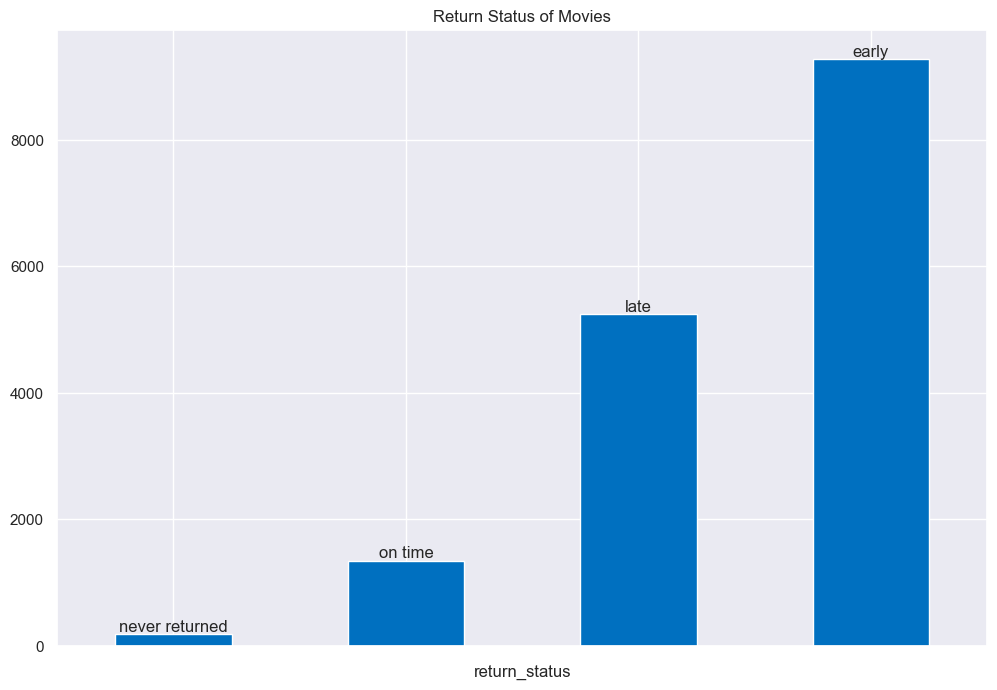

In [30]:
# lets plot it 

ax = df.plot.bar(x='return_status', figsize=(12, 8), color = '#0070C0')
plt.ylabel("Count")
plt.title("Return Status of Movies")
ax.set_xticklabels([])
plt.legend().set_visible(False)
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, labels = df['return_status'].value_counts().keys())
    